<h1> Exploracion de los Datos (EDA) </h1>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('../data/processed/online_retail_II_cleaned.parquet')

In [17]:
# Confiuracion inicial para graficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Verificacion Inicial de los Datos

### Veficiacion Tipos de Datos

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400916 entries, 0 to 400915
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoice      400916 non-null  string        
 1   stockcode    400916 non-null  string        
 2   description  400916 non-null  string        
 3   quantity     400916 non-null  int16         
 4   invoicedate  400916 non-null  datetime64[ns]
 5   price        400916 non-null  float32       
 6   customer_id  400916 non-null  Int32         
 7   country      400916 non-null  string        
dtypes: Int32(1), datetime64[ns](1), float32(1), int16(1), string(4)
memory usage: 19.5 MB


### Verificacion de valores negativos o iguales a cero en las variables '`quantity`' y '`price`'

In [19]:
print(f"Cantidades con valores iguales o menores a cero: {(df['quantity'] <= 0).sum()}")
print(f"Precios con valores iguales o menores a cero: {(df['price'] <= 0).sum()}")

Cantidades con valores iguales o menores a cero: 0
Precios con valores iguales o menores a cero: 0


### Estadistica Descriptiva de las Variables '`quantity`' y '`price`'

In [20]:
df[['quantity', 'price']].describe()

,quantity,price
count,400916.000000,400916.000000
mean,13.767418,3.305826
std,97.638385,35.016792
min,1.000000,0.001000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,19152.000000,10953.500000


En la variable *`quantity`*, la mediana es de **5**, mientras que el promedio es de **13.77**, lo que indica que la mayoría de las transacciones involucran pocas unidades, pero existen compras excepcionalmente grandes que elevan la media. Esto se refuerza con un valor máximo de **19,152** y una desviación estándar elevada (**97.64**), evidenciando una alta dispersión y una distribución sesgada a la derecha.

Para la variable *`price`*, la mediana es de **1.95** y el promedio alcanza **3.31**, lo que sugiere que la mayoría de los productos tienen precios bajos, aunque existen artículos con precios extremadamente altos. El valor máximo de **10,953.5** y la desviación estándar de **35.02** confirman una alta variabilidad y la presencia de outliers.

### Verificacion de Fechas y Clientes unicos

In [21]:
print(f"Rango de Fechas: {df['invoicedate'].dt.date.min()} a {df['invoicedate'].dt.date.max()}")
print(f"Total Clientes Únicos: {df['customer_id'].nunique()}")

Rango de Fechas: 2009-12-01 a 2010-12-09
Total Clientes Únicos: 4312


Se valida que el dataset sea temporalmente suficiente y estadísticamente adecuado para estimar el CLTV en un horizonte de 6 meses. Ademas se verifica el tamaño de clientes unicos en todo el dataset y para el periodo de entrenamiento.

## Creacion de Variable Monetaria

In [22]:
df['total_spend'] = df['quantity'] * df['price']
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country,total_spend
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.399994
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.000000
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.000000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.799995
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.000000


Calcular el monto monetario de cada transacción, que será la base para estimar el valor económico del cliente en el modelo de CLTV a 6 meses.

- Permite medir cuánto gasta cada cliente en cada compra.
- Facilita la agregación posterior a nivel cliente (gasto promedio, gasto total).

### Validaciones de la Variable Monetaria

In [23]:
print((df['total_spend'] > 0).sum())

400916


Se valida que la variable monetaria no contenga valores negativos, ya que esto podría distorsionar los cálculos de CLTV. El resultado indica que todos los valores son positivos, lo cual es adecuado para el análisis.

### Resumen estadístico de la Variable Monetaria

In [24]:
df['total_spend'].describe()

count    400916.000000
mean         21.945330
std          77.734238
min           0.001000
25%           5.000000
50%          12.500000
75%          19.500000
max       15818.400391
Name: total_spend, dtype: float64

En la estadistica descriptiva de la variable monetaria (*`total_spend`*), se observa que el promedio de gasto por transaccion es de aproximadamente **21.9**, con una mediana de **12.0**, lo que indica que la mayoria de las transacciones son de montos relativamente bajos. Sin embargo, el valor maximo alcanza los **15818.4**, lo que sugiere la presencia de algunas transacciones excepcionalmente altas que pueden influir en el promedio. La desviacion estandar es bastante alta (**77.73**), lo que refuerza la idea de una gran variabilidad en los montos gastados por los clientes, indicando a la vez una distribucion sesgada hacia la derecha.

## Cálculo de métricas RFM a nivel cliente

In [33]:
# Fecha de referencia (el día siguiente a la última compra del dataset)
snapshot_date = df['invoicedate'].max() + pd.to_timedelta(1, unit='D')

# Agregación por Cliente (RFM)
rfm = df.groupby('customer_id').agg({
    'invoicedate': lambda x: (snapshot_date - x.max()).days, # Recencia
    'invoice': 'nunique',                                    # Frecuencia
    'total_spend': 'sum'                                     # Valor Monetario
}).rename(columns={
    'invoicedate': 'Recency',
    'invoice': 'Frequency',
    'total_spend': 'Monetary'
})

rfm.head()


,Recency,Frequency,Monetary
customer_id,,,
12346,165,11,372.859985
12347,3,2,1323.320068
12348,74,1,222.160019
12349,43,3,2671.139893
12351,11,1,300.929993


Se obtienen las fechas de ultima compra, frecuencia de compras y monto monetario total por cliente, que son fundamentales para segmentar a los clientes y predecir su valor futuro.

De esta manera, se crea el DataFrame `rfm` que contiene las métricas RFM (Recencia, Frecuencia y Valor Monetario) para cada cliente, lo cual es esencial para el análisis de CLTV.

- **Recencia**: Días desde la última compra hasta la fecha de referencia (snapshot_date).
- **Frecuencia**: Número de compras únicas realizadas por el cliente.
- **Valor Monetario**: Suma total gastada por el cliente.

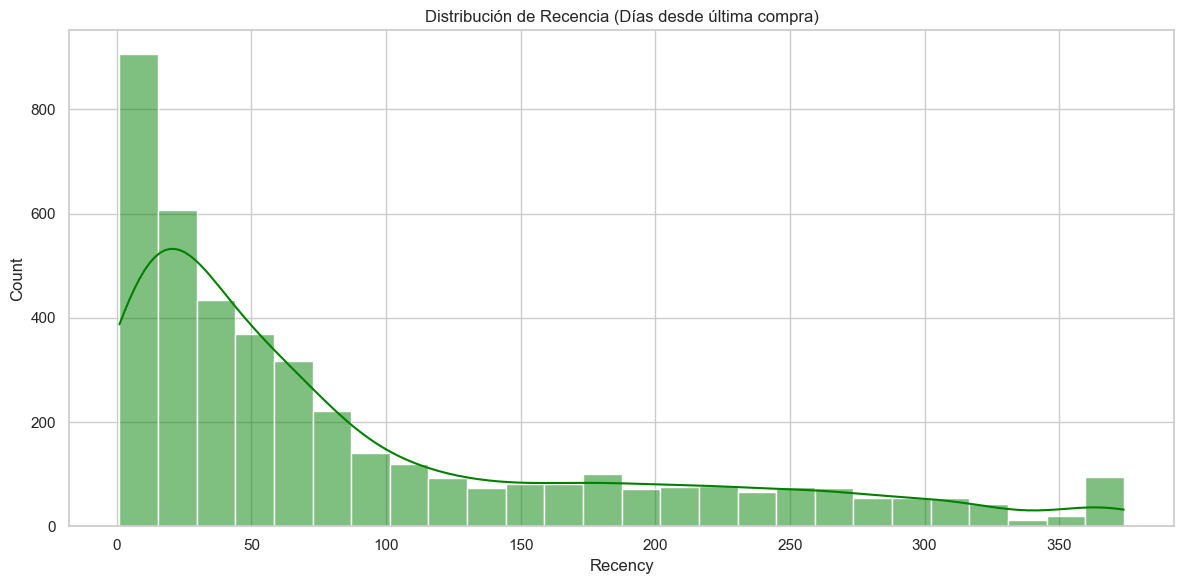

In [ ]:
sns.histplot(rfm['Recency'], kde=True, color='green')
plt.title('Distribución de Recencia (Días desde última compra)')
plt.tight_layout()
plt.show()

La distribución de recency muestra la cantidad de clientes según los días transcurridos desde su última compra, evidenciando una alta concentración de clientes activos y una cola larga correspondiente a clientes inactivos o en churn, comportamiento esperado para modelos de CLTV.

Esta gráfica muestra cuántos clientes existen según los días transcurridos desde su última compra. La alta concentración de clientes con recencias bajas indica que una parte importante del mercado está activa recientemente, mientras que la cola larga hacia la derecha representa clientes inactivos o en churn. Esta forma sesgada es esperada en datos de comportamiento de compra y confirma que la recencia está correctamente calculada. A partir de esta gráfica se valida que el uso de modelos de recurrencia como BG/NBD es apropiado y no se requieren transformaciones adicionales sobre esta variable.

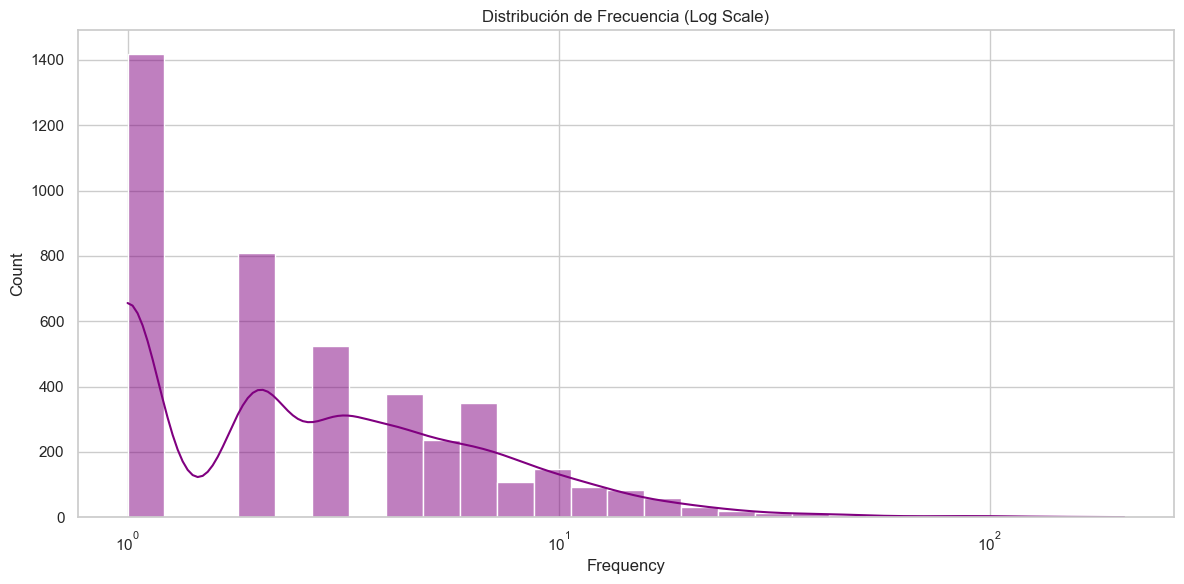

In [29]:
sns.histplot(rfm['Frequency'], kde=True, log_scale=True, color='purple')
plt.title('Distribución de Frecuencia (Log Scale)')
plt.tight_layout()
plt.show()


La distribución de frecuencia muestra que la mayoría de los clientes realiza una sola compra, mientras que un pequeño grupo presenta una alta recurrencia, patrón típico de cola larga esperado en modelos de CLTV.

Esta gráfica muestra la cantidad de clientes según el número de compras realizadas. Se observa un pico pronunciado en frecuencia igual a uno, lo que indica que la mayoría de los clientes realizó una sola compra, seguido de una caída rápida y una cola larga que representa clientes altamente recurrentes. Este patrón es típico en negocios reales y confirma la existencia de pocos clientes muy leales. La escala logarítmica permite visualizar adecuadamente esta cola larga sin perder detalle en los valores bajos.

Qué procede: separar los clientes con frecuencia mayor a uno para el modelado del valor monetario (Gamma-Gamma), manteniendo a todos los clientes para el modelo de recurrencia (BG/NBD).

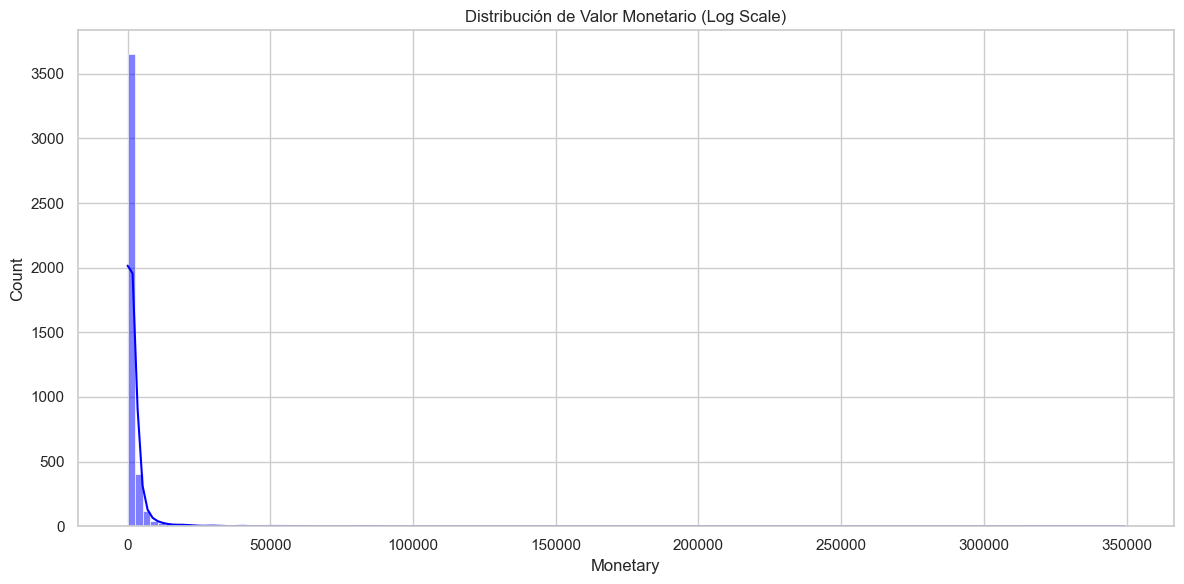

In [32]:
sns.histplot(rfm['Monetary'], kde=True, color='blue')
plt.title('Distribución de Valor Monetario (Log Scale)')
plt.tight_layout()
plt.show()


La distribución del valor monetario muestra una fuerte heterogeneidad en el gasto total de los clientes, con una cola larga hacia la derecha, comportamiento esperado y necesario para el modelado de CLTV mediante Gamma-Gamma.

Esta gráfica muestra la distribución del gasto total por cliente, evidenciando una fuerte heterogeneidad en el valor generado. La mayoría de los clientes se concentra en rangos monetarios bajos y medios, mientras que una minoría presenta valores significativamente altos, formando una cola larga hacia la derecha. Este comportamiento es característico de distribuciones tipo Pareto y es un supuesto fundamental del modelo Gamma-Gamma. La ausencia de valores negativos o discontinuidades indica que la variable monetaria fue correctamente construida.

Qué procede: utilizar la variable monetaria sin eliminar outliers altos, ya que estos representan clientes de alto valor que el CLTV debe capturar.